In [1]:
import numpy as np
from sdm_ml.dataset import BBSDataset
from sklearn.preprocessing import StandardScaler
from kernels import ard_rbf_kernel
import matplotlib.pyplot as plt
%matplotlib inline
from sksparse.cholmod import cholesky
import scipy.sparse as sps
from scipy.special import expit

In [2]:
csv_folder = '../../../multi_species/bbs/dataset/csv_bird_data/'
dataset = BBSDataset(csv_folder)

In [3]:
training_set = dataset.get_training_set()

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

covariates = scaler.fit_transform(training_set['covariates'].values)
outcomes = training_set['outcomes'][['American Crow', 'Brown-headed Cowbird']]

scaler = StandardScaler()

# Keep only the first 200 rows and 2 outcomes for this test
covariates = scaler.fit_transform(covariates.astype(np.float32))[:, :]
outcomes = outcomes.values[:, :2]

y_flat = np.reshape(outcomes[:, 0], (-1), order='F').astype(float)

/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


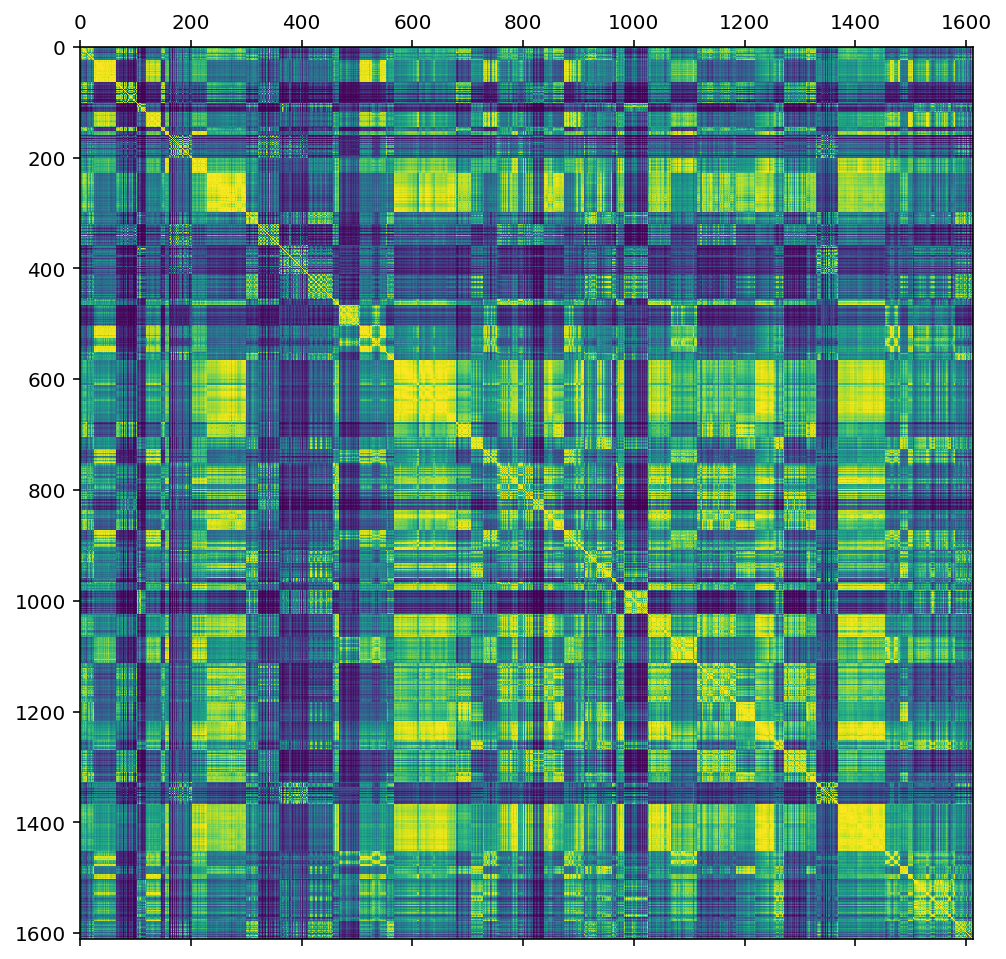

In [67]:
K1, l1_grad, s1_grad = ard_rbf_kernel(covariates, covariates, np.linspace(2, 4, 8), 1., jitter=1e-5)
K = sps.csc_matrix(K1)

plt.matshow(K.todense())
plt.gcf().set_size_inches(8, 8)

In [68]:
l1_grad.shape

(1612, 1612, 8)

In [69]:
# Try to follow R & W to the letter

In [71]:
def find_mode(K, y):
    
    f = np.zeros(K.shape[0])
    old_f = np.ones_like(f)
    
    while np.sum((f - old_f)**2) > 1e-8:

        probs = expit(f)
        grad_log_y = y_flat - probs

        W = sps.csc_matrix(np.diag(probs * (1 - probs)))
        W_sqrt = np.sqrt(W)
        multiplied = W_sqrt.dot(K).dot(W_sqrt)

        B = multiplied + sps.eye(K.shape[0], format='csc')
        L = cholesky(B)
        b = W.dot(f) + grad_log_y

        first_solve = L.solve_L(W_sqrt.dot(K.dot(b)), False)
        second_solve = L.solve_Lt(first_solve, False)

        a = b - W_sqrt.dot(second_solve)
        old_f = f
        f = K.dot(a)
        
    # Calculate the log marginal likelihood
    log_lik = np.sum(y * f - np.log1p(np.exp(f)))
    log_marg_lik = -0.5 * a.T.dot(f) + log_lik - np.log(L.L().diagonal()).sum()

    return f, log_marg_lik

In [72]:
s1_grad.shape

(1612, 1612)

In [73]:
def log_marg_lik_and_grad(hyperparams):
    
    lengthscales = hyperparams[:-1]
    variance = hyperparams[-1]

    K1, l1_grad, s1_grad = ard_rbf_kernel(covariates, covariates, lengthscales, 
                                          variance, jitter=1e-5)
    
    K = sps.csc_matrix(K1)
    
    all_grads = np.concatenate([l1_grad, np.expand_dims(s1_grad, axis=2)], axis=2)

    f, Z = find_mode(K, y_flat)

    probs = expit(f)

    grad_log_y = y_flat - probs
    third_grad = expit(f) - 3 * expit(f)**2 + 2 * expit(f)**3

    W = sps.csc_matrix(np.diag(probs * (1 - probs)))
    W_sqrt = np.sqrt(W)
    multiplied = W_sqrt.dot(K).dot(W_sqrt)

    B = multiplied + sps.eye(K.shape[0], format='csc')

    L = cholesky(B)
    b = W.dot(f) + grad_log_y

    first_solve = L.solve_L(W_sqrt.dot(K.dot(b)), False)
    second_solve = L.solve_Lt(first_solve, False)
    a = b - W_sqrt.dot(second_solve)

    R = W_sqrt.dot(L.solve_Lt(L.solve_L(W_sqrt, False), False))
    C = L.solve_L(W_sqrt.dot(K), False)

    diag_diff = sps.csc_matrix(np.diag(K.diagonal() - C.transpose().dot(C).diagonal()))
    s2 = -0.5 * diag_diff.dot(third_grad)

    grads = list()

    for cur_grad in range(all_grads.shape[2]):

        C = all_grads[:, :, cur_grad]
        s1 = 0.5 * a.T.dot(C).dot(a) - 0.5 * np.sum(R.dot(C).diagonal())
        b = C.dot(grad_log_y)
        s3 = b - K.dot((R.dot(b)))
        grads.append(s1 + s2.T.dot(s3))
        
    print(Z)
        
    return Z, np.array(grads)

In [74]:
log_marg_lik_and_grad(np.concatenate([np.linspace(2, 4, 8), [1.]]))[1]

-528.8163557291023


array([ 1.23232904,  1.54575871, -6.96991181, -1.45161674,  0.32031559,
       -2.41205886, -2.99240726, -3.10347864, 67.56753452])

In [75]:
from scipy.optimize import fmin_cg

In [76]:
to_minimise = lambda x: -log_marg_lik_and_grad(x)[0]
grads = lambda x: -log_marg_lik_and_grad(x)[1]

In [77]:
fmin_cg(to_minimise, x0=np.concatenate([np.linspace(2, 4, 8), [1.]]), fprime=grads, gtol=1e-2)

-528.8163557291023
-528.8163557291023
-494.72341369718845
-494.72341369718845
-482.59257630539764
-482.59257630539764
-477.1874770798072
-477.1874770798072
-477.7974566966203
-477.7974566966203
-483.7412216449628
-483.7412216449628
-475.47900391397377
-475.47900391397377
-475.9066020576597
-475.9066020576597
-474.2659636352412
-474.2659636352412
-474.0027799546083
-474.0027799546083
-472.58638288854877
-472.58638288854877
-471.872945139463
-471.872945139463
-483.40968131763395
-483.40968131763395
-471.45369527387953
-471.45369527387953
-471.1766068128851
-471.1766068128851
-471.1242565198165
-471.1242565198165
-470.9481754501601
-470.9481754501601
-470.89627390469843
-470.89627390469843
-470.6665800987221
-470.6665800987221
-470.45567879867434
-470.45567879867434
-470.3106267358329
-470.3106267358329
-470.2275821731781
-470.2275821731781
-470.20964782085144
-470.20964782085144
-470.544266306444
-470.544266306444
-470.189290139538
-470.189290139538
-470.1626495746882
-470.1626495746882


array([1.89833777, 0.98259289, 1.08901049, 2.57958556, 4.8565387 ,
       2.66783184, 2.90055602, 2.14984156, 2.85403129])